In [ ]:
# dataset @ https://finance.yahoo.com/quote/ETH_USD/history/

In [1]:
import san
import pandas as pd
ohlc_df = san.get(
'ohlc/ethereum',
from_date='2017-09-01',
to_date='2023-03-07', # TODAY (Change after 00:00:00 GMT OR 18:00:00 CST)
interval='1d')
d_f = pd.DataFrame(ohlc_df)
d_f = d_f.rename(columns={'closePriceUsd':'Close','highPriceUsd':'High','lowPriceUsd':'Low','openPriceUsd':'Open'})
d_f = d_f.drop(columns=['High','Low','Open'])
d_f.index.names = ['Date']
d_f.head()

,Close
Date,
2017-09-01 00:00:00+00:00,387.741
2017-09-02 00:00:00+00:00,348.984
2017-09-03 00:00:00+00:00,347.484
2017-09-04 00:00:00+00:00,295.171
2017-09-05 00:00:00+00:00,312.988


In [2]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

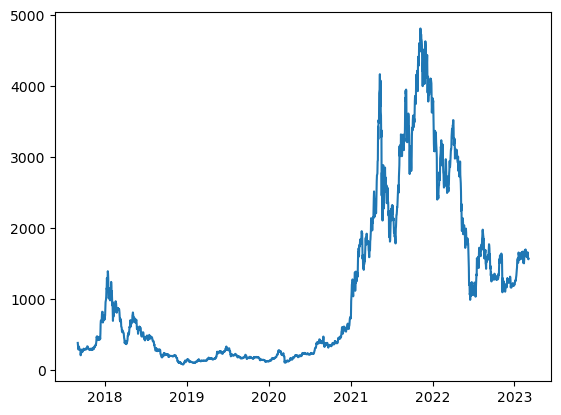

In [3]:
import matplotlib.pyplot as plt

plt.plot(d_f.index, d_f['Close'])

In [5]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# change to today after 00:00 GMT
windowed_df = df_to_windowed_df(d_f, 
                                '2020-11-18', 
                                '2023-03-07', 
                                n=3)
windowed_df

/opt/anaconda3/envs/dev/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  
/opt/anaconda3/envs/dev/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.


,Target Date,Target-3,Target-2,Target-1,Target
0,2020-11-18,447.559095,460.073824,480.360083,479.484070
1,2020-11-19,460.073824,480.360083,479.484070,471.630420
2,2020-11-20,480.360083,479.484070,471.630420,509.744573
3,2020-11-21,479.484070,471.630420,509.744573,549.486621
4,2020-11-22,471.630420,509.744573,549.486621,558.068095
...,...,...,...,...,...
834,2023-03-02,1634.326368,1605.895131,1663.433656,1647.319279
835,2023-03-03,1605.895131,1663.433656,1647.319279,1569.167653
836,2023-03-04,1663.433656,1647.319279,1569.167653,1566.923943
837,2023-03-05,1647.319279,1569.167653,1566.923943,1564.468721


In [6]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((839,), (839, 3, 1), (839,))

- Test on all data, predict future price (1 day):

- Testing over a period of time:

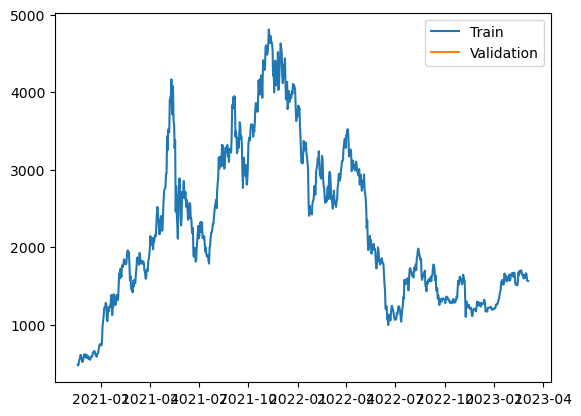

In [17]:
q_95 = int(len(dates) * .95)
q_99 = int(len(dates) * .998809)

dates_train, X_train, y_train = dates[:q_99], X[:q_99], y[:q_99]

dates_val, X_val, y_val = dates[q_95:q_99], X[q_95:q_99], y[q_95:q_99]
dates_test, X_test, y_test = dates[q_99:], X[q_99:], y[q_99:]

plt.plot(dates_train, y_train)
# plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [18]:
X_test

array([[[1569.1676],
        [1566.924 ],
        [1564.4688]]], dtype=float32)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
27/27 [==============================] - 4s 30ms/step - loss: 6003627.0000 - mean_absolute_error: 2225.3591 - val_loss: 2608744.7500 - val_mean_absolute_error: 1614.3240
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 5995402.0000 - mean_absolute_error: 2223.5042 - val_loss: 2600652.5000 - val_mean_absolute_error: 1611.8156
Epoch 3/100
27/27 [==============================] - 0s 6ms/step - loss: 5978549.0000 - mean_absolute_error: 2219.6409 - val_loss: 2582485.0000 - val_mean_absolute_error: 1606.1699
Epoch 4/100
27/27 [==============================] - 0s 5ms/step - loss: 5943945.0000 - mean_absolute_error: 2211.8716 - val_loss: 2548175.0000 - val_mean_absolute_error: 1595.4535
Epoch 5/100
27/27 [==============================] - 0s 5ms/step - loss: 5882309.5000 - mean_absolute_error: 2197.8813 - val_loss: 2490506.7500 - val_mean_absolute_error: 1577.2771
Epoch 6/100
27/27 [==============================] - 0s 6ms/step - loss: 5781042.5000 - mean_a

27/27 [==============================] - 1s 2ms/step


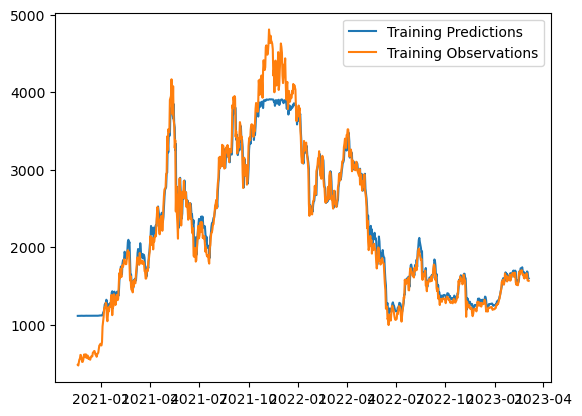

In [20]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 4ms/step


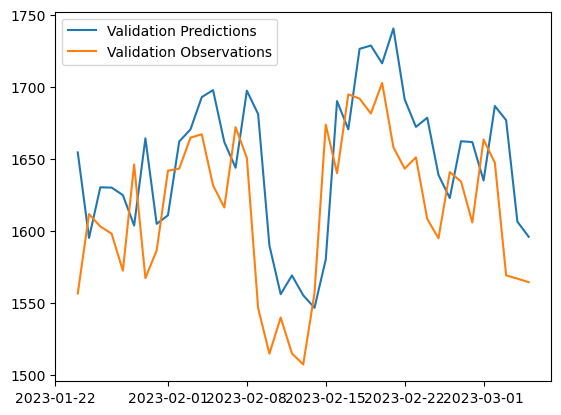

In [21]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 28ms/step


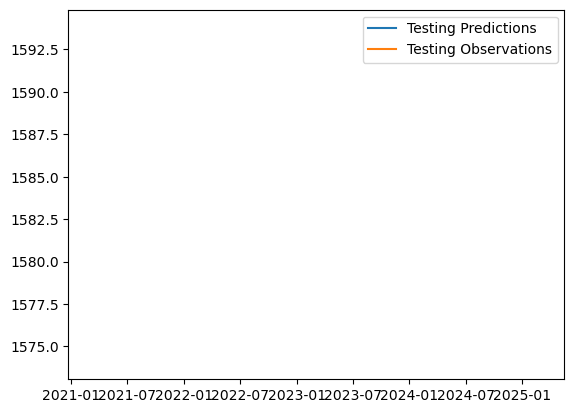

In [22]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [24]:
test_predictions

array([1593.854], dtype=float32)

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

## Future Predictions (NA)

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])